In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import csv
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN, MeanShift
from sklearn.preprocessing import StandardScaler
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = 'https://www.coindesk.com/en/price'
response = requests.get(url)
html_content = response.text
response

<Response [200]>

In [4]:
scraper = BeautifulSoup(html_content, 'html.parser')

In [5]:
table = scraper.find_all('table')[0]
rows = table.find_all('tr')
headers = [header.text.strip() for header in table.find_all('th')]
for i in range(1, min(len(rows), 21)):
    row = rows[i]
    cells = [cell.text.strip() for cell in row.find_all('td')]
    if cells:
        data = dict(zip(headers, cells))
        print(data)

{'#': '1', 'Asset': 'BitcoinBTC', '': '', 'Price': '$106,922.27', 'Market Cap': '$2.13T', '24h Volume': '$38.42B', '24h': '1.19%', '7d': '-3.51%', '30d': '-8.70%', 'Last 7 Days': ''}
{'#': '2', 'Asset': 'EthereumETH', '': '', 'Price': '$3,874.61', 'Market Cap': '$467.66B', '24h Volume': '$21.30B', '24h': '3.08%', '7d': '3.29%', '30d': '-15.57%', 'Last 7 Days': ''}
{'#': '3', 'Asset': 'TetherUSDT', '': '', 'Price': '$1.00', 'Market Cap': '$181.76B', '24h Volume': '$704.02M', '24h': '0.02%', '7d': '-0.06%', '30d': '0.03%', 'Last 7 Days': ''}
{'#': '4', 'Asset': 'Binance CoinBNB', '': '', 'Price': '$1,110.20', 'Market Cap': '$154.52B', '24h Volume': '$3.18B', '24h': '1.32%', '7d': '-2.31%', '30d': '13.13%', 'Last 7 Days': ''}
{'#': '5', 'Asset': 'XRPXRP', '': '', 'Price': '$2.35', 'Market Cap': '$141.14B', '24h Volume': '$4.59B', '24h': '2.60%', '7d': '-1.35%', '30d': '-23.46%', 'Last 7 Days': ''}
{'#': '6', 'Asset': 'SolanaSOL', '': '', 'Price': '$186.54', 'Market Cap': '$102.03B', '24h 

In [6]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    table = scraper.find_all('table')[0]
    rows = table.find_all('tr')
    headers = [header.text.strip() for header in table.find_all('th')]
    for i in range(1, min(len(rows), 21)):
        row = rows[i]
        cells = [cell.text.strip() for cell in row.find_all('td')]
        if cells:
            writer.writerow(cells)

In [7]:
df = pd.read_csv('output.csv')

In [8]:
df.head(5)

,#,Asset,Unnamed: 2,Price,Market Cap,24h Volume,24h,7d,30d,Last 7 Days
0,1,BitcoinBTC,NaN,"$106,922.27",$2.13T,$38.42B,1.19%,-3.51%,-8.70%,NaN
1,2,EthereumETH,NaN,"$3,874.61",$467.66B,$21.30B,3.08%,3.29%,-15.57%,NaN
2,3,TetherUSDT,NaN,$1.00,$181.76B,$704.02M,0.02%,-0.06%,0.03%,NaN
3,4,Binance CoinBNB,NaN,"$1,110.20",$154.52B,$3.18B,1.32%,-2.31%,13.13%,NaN
4,5,XRPXRP,NaN,$2.35,$141.14B,$4.59B,2.60%,-1.35%,-23.46%,NaN


In [9]:
df.drop(['Unnamed: 2'], axis=1, inplace=True)
df.drop(['Last 7 Days'], axis=1, inplace=True)

In [10]:
def parse_abbreviated_number(value):
    if pd.isna(value):
        return value
    
    value = str(value).strip().replace('$', '').replace(',', '')
    
    multipliers = {
        'K': 10**3, 'M': 10**6, 'B': 10**9, 'T': 10**12
    }
    
    if value[-1].upper() in multipliers:
        number = float(value[:-1])
        multiplier = value[-1].upper()
        return number * multipliers[multiplier]
    else:
        return float(value)

In [11]:
df_pca = df.drop(['Asset'], axis=1)
df_pca = df_pca.drop(['#'], axis=1)
df_pca['Market Cap'] = df_pca['Market Cap'].apply(parse_abbreviated_number)
df_pca['24h Volume'] = df_pca['24h Volume'].apply(parse_abbreviated_number)
for col in df_pca.columns:
    if df_pca[col].dtype == 'object':
        df_pca[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))
df_pca['24h'] = df_pca['24h'].map(lambda x: abs(float(x)))
df_pca['7d'] = df_pca['7d'].map(lambda x: abs(float(x)))
df_pca['30d'] = df_pca['30d'].map(lambda x: abs(float(x)))

In [12]:
df_pca.head()

,Price,Market Cap,24h Volume,24h,7d,30d
0,106922.27,2.130000e+12,3.842000e+10,1.19,3.51,8.70
1,3874.61,4.676600e+11,2.130000e+10,3.08,3.29,15.57
2,1.00,1.817600e+11,7.040200e+08,0.02,0.06,0.03
3,1110.20,1.545200e+11,3.180000e+09,1.32,2.31,13.13
4,2.35,1.411400e+11,4.590000e+09,2.60,1.35,23.46


In [13]:
scaler = StandardScaler()
df_pca = scaler.fit_transform(df_pca)

In [14]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [15]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['Asset'] = df['Asset']

Text(0.5, 1.0, 'PCA - First Two Components')

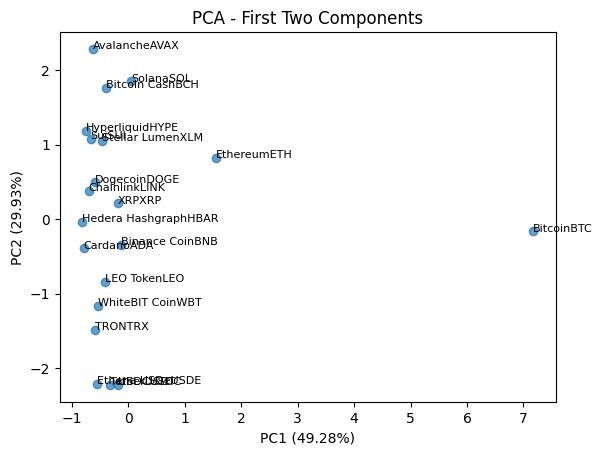

In [16]:
plt.subplot(1, 1, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
for i, symbol in enumerate(pca_df['Asset']):
    plt.annotate(symbol, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=8)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA - First Two Components')

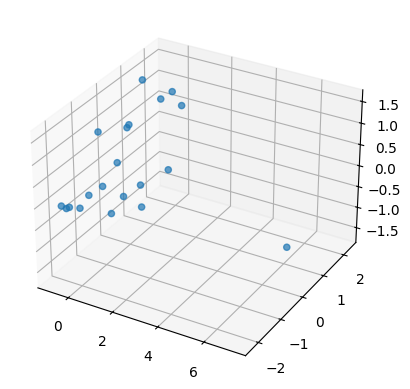

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.7)
for i, symbol in enumerate(pca_df['Asset']):
    ax.annotate(symbol, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=8)

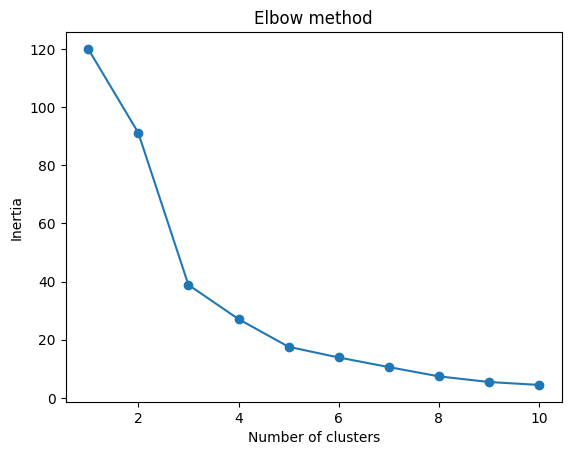

In [18]:
inertias = []
for i in range(1,11):
    kmeans_elbow = KMeans(n_clusters=i)
    kmeans_elbow.fit(df_pca)
    inertias.append(kmeans_elbow.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [36]:
df_pca_2d = pca_df[['PC1', 'PC2']].copy()

clusters = 4

kmeans = KMeans(n_clusters=clusters)
crypto_types_kmeans = kmeans.fit_predict(df_pca_2d)

agglomerative = AgglomerativeClustering(n_clusters=clusters)
crypto_types_agglomerative = agglomerative.fit_predict(df_pca_2d)

dbscan = DBSCAN(min_samples=3)
crypto_types_dbscan = dbscan.fit_predict(df_pca_2d)

hdbscan = HDBSCAN(min_cluster_size=3, min_samples=2)
crypto_types_hdbscan = hdbscan.fit_predict(df_pca_2d)

mean_shift = MeanShift(bandwidth=1)
crypto_types_meanshift = mean_shift.fit_predict(df_pca_2d)

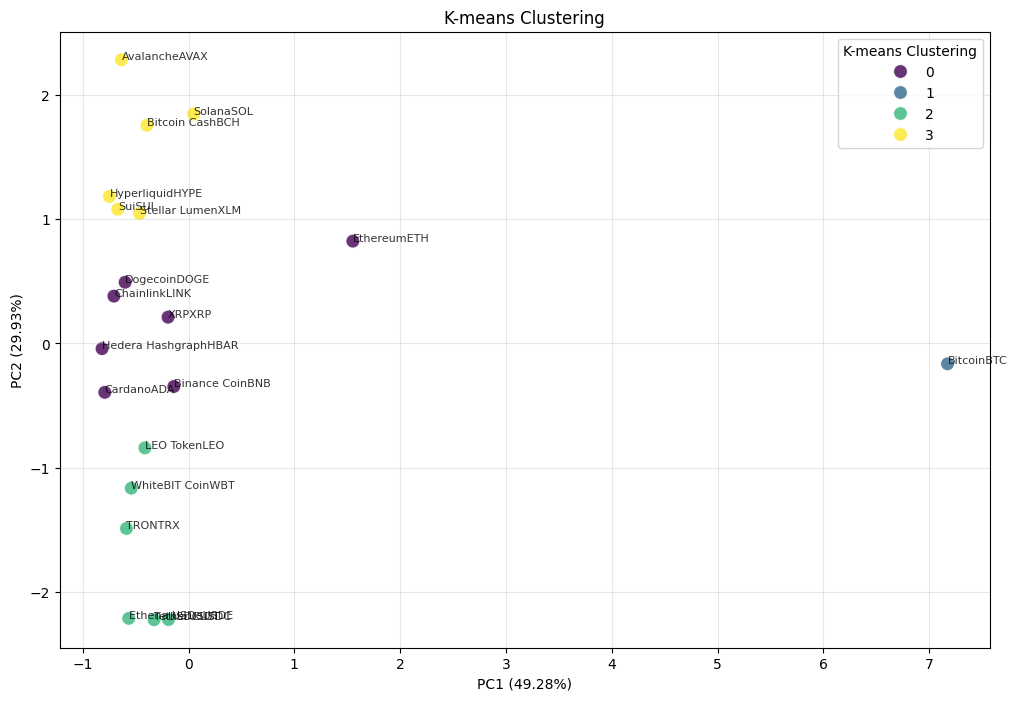

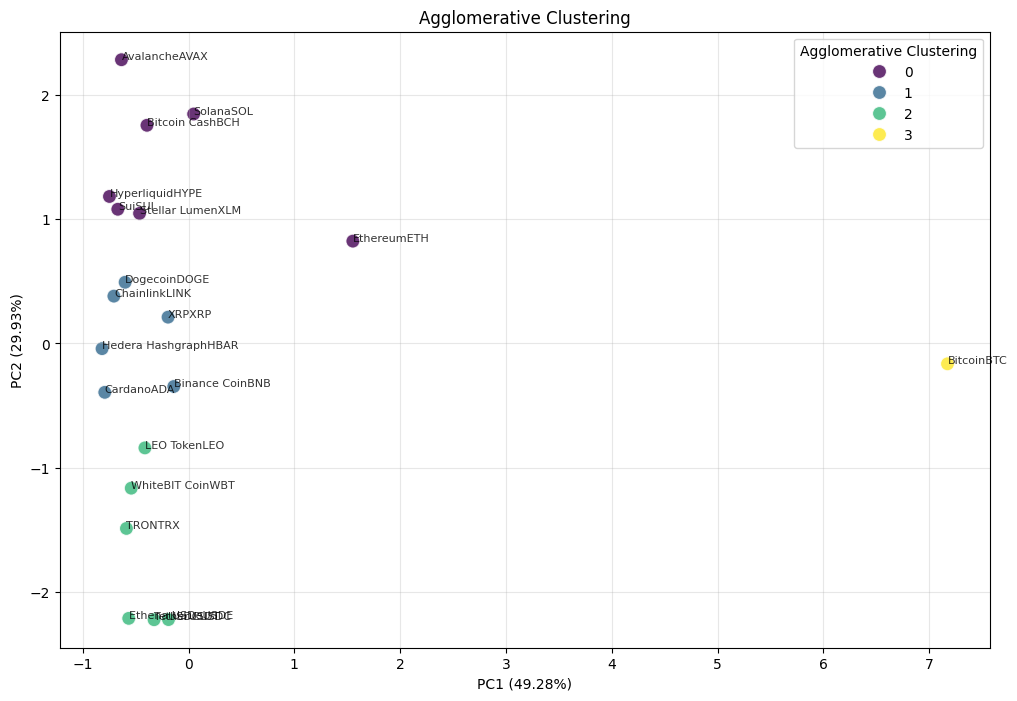

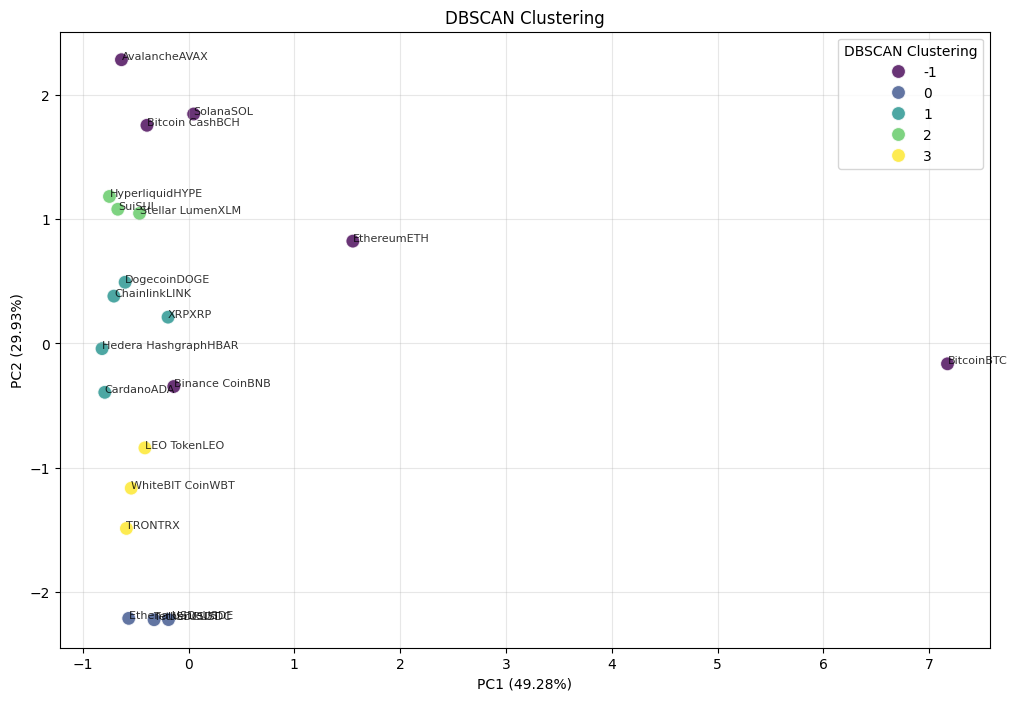

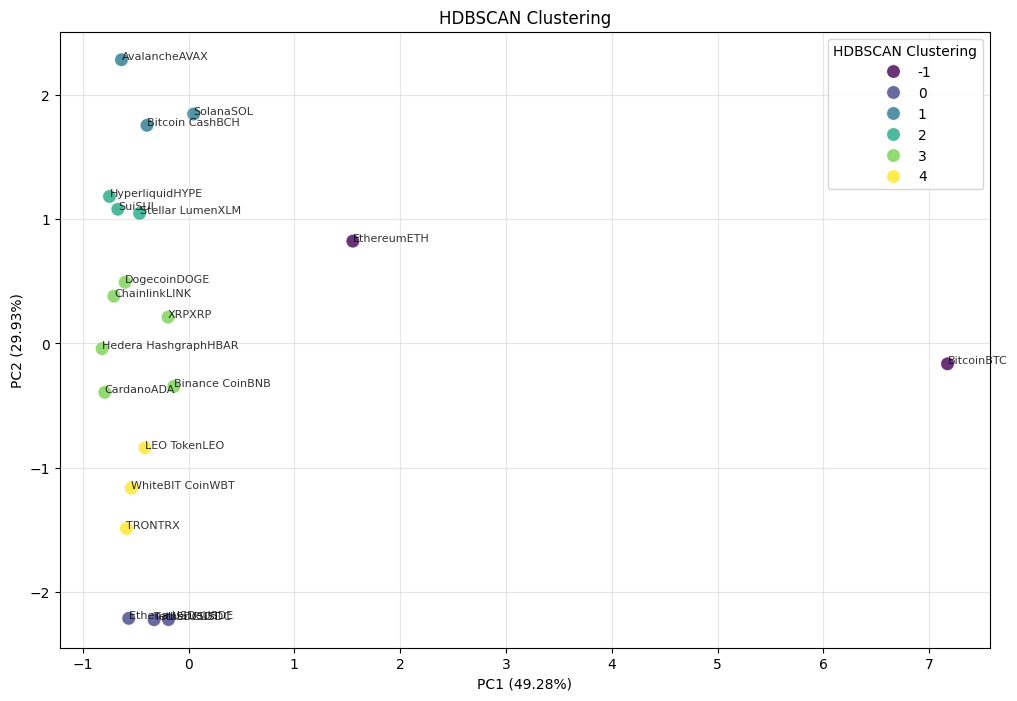

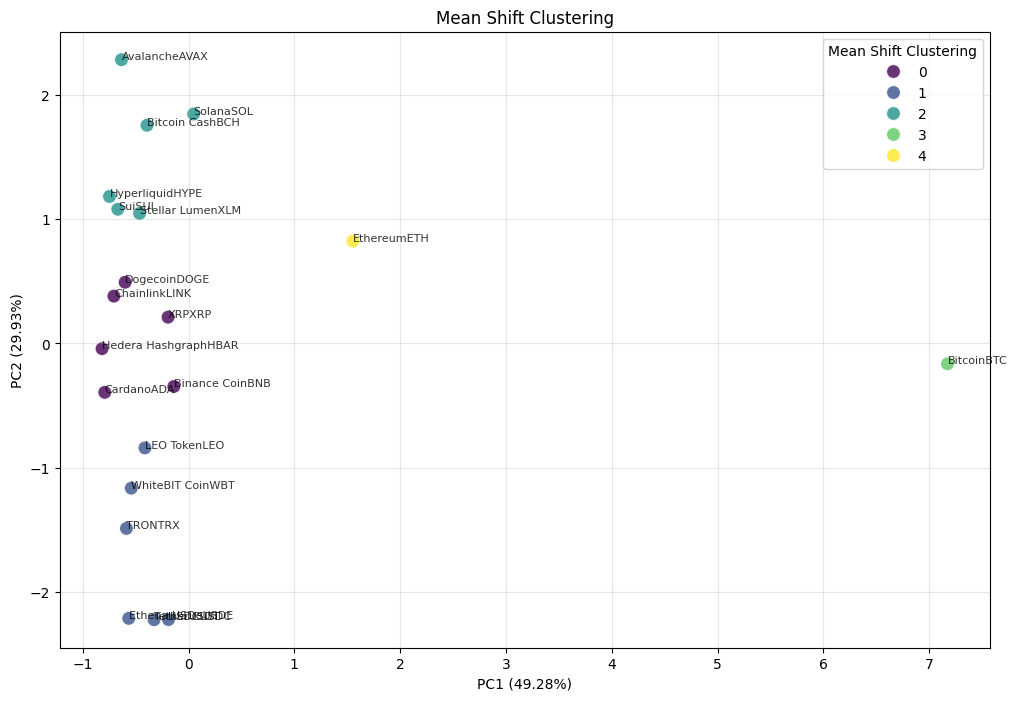

In [37]:
# K-means Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Asset']].copy()
plot_df['Cluster'] = crypto_types_kmeans

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Asset'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('K-means Clustering')
plt.legend(title='K-means Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# Agglomerative Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Asset']].copy()
plot_df['Cluster'] = crypto_types_agglomerative

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Asset'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Agglomerative Clustering')
plt.legend(title='Agglomerative Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# DBSCAN Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Asset']].copy()
plot_df['Cluster'] = crypto_types_dbscan

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Asset'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('DBSCAN Clustering')
plt.legend(title='DBSCAN Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# HDBSCAN Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Asset']].copy()
plot_df['Cluster'] = crypto_types_hdbscan

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Asset'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('HDBSCAN Clustering')
plt.legend(title='HDBSCAN Clustering')
plt.grid(True, alpha=0.3)
plt.show()

# Mean Shift Clustering
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'Asset']].copy()
plot_df['Cluster'] = crypto_types_meanshift

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['Asset'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Mean Shift Clustering')
plt.legend(title='Mean Shift Clustering')
plt.grid(True, alpha=0.3)
plt.show()